In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import time
import random

## Data Generation Algorithm

In [2]:
def create_data_linspace(n, 
                n_effective_groups, 
                n_visible_groups,
                n_contineous_features, 
                mode, 
                fe_beta = (0,1), 
                re_intercept = (-10,10), # linspace random intercpt
                re_slope = (-10,10),     # linspace random slope
                fe_error = (0,1),        # normal distributed global error
                global_intercept = 0,
                show_random_effects = False):
    
    def make_visible_split(N, m):
        base_split_size, remainder = divmod(N, m)
        splits = [base_split_size] * m  # Create splits with equal base sizes
        for i in range(remainder):
            splits[i] += 1 
        result_dict = {i: splits[i] for i in range(m)}
        return splits

    def make_effective_split(arr, g):
        if g <= 0:
            raise ValueError("The value of 'g' must be greater than 0")

        combined_splits = [0] * g  # Initialize the combined_splits list with g zeros
        groups = [[] for _ in range(g)]  # Create g empty groups

        for i, num in enumerate(arr):
            group_index = i % g  # Determine the group index using modulus
            groups[group_index].append(num)  # Assign the element to the corresponding group

        for i in range(g):
            combined_splits[i] = sum(groups[i])  # Calculate the sum for each group

        groups = [item for sublist in groups for item in sublist]
        return combined_splits, groups

    size = n
    nEg = n_effective_groups
    nVg = n_visible_groups
    
    allowed_modes = ['intercept', 'slope', 'both']
    if mode not in allowed_modes:
        raise ValueError(f"Invalid mode '{mode}'. Please choose one of {', '.join(allowed_modes)}.")
    
    # generating fixed effect part
    X = np.random.uniform(-1, 1, size * n_contineous_features).reshape((size, n_contineous_features))
    fixed_slope = np.random.normal(fe_beta[0],fe_beta[1], size = n_contineous_features)
    data = pd.DataFrame(X)
    x_cols = ['f' + str(i) for i in range(n_contineous_features)]
    data.columns = x_cols
    e = np.random.normal(fe_error[0], fe_error[1], size)
    y = global_intercept + X @ fixed_slope + e
    
    random_effects = {}
    
    ########### Creating effective splits ############
    
    v_splits = make_visible_split(size, nVg)
    e_splits, v_splits = make_effective_split(v_splits, nEg)
    data['gE'] = np.repeat(range(nEg), e_splits)
    
    if mode == 'intercept':
        
        random_intercept = np.linspace(re_intercept[0], re_intercept[1], num = len(e_splits)) + \
                                                                np.random.normal(0,1, size = len(e_splits))
        u0 = np.repeat(random_intercept, e_splits)
        random_effects['intercept'] = u0
        random_effects['Y_Fixed'] = y
        y = y + u0
        
    if mode == 'slope':
            
        X_split = np.split(X, np.cumsum(e_splits)[:-1])
        slopes = np.linspace(re_slope[0], re_slope[1], num = len(e_splits)*n_contineous_features) +\
                                                        np.random.normal(0,1, size = n_contineous_features*len(e_splits))
        slopes = slopes.reshape(n_effective_groups, n_contineous_features)
        
        re_slopes = np.repeat(slopes, e_splits, axis=0)
        for i in range(re_slopes.shape[1]):
            random_effects["slope_f"+str(i)] = re_slopes[:,i] 
            
        random_effects['Y_Fixed'] = y
        
        for i in range(len(X_split)):
            X_split[i] = X_split[i] * slopes[i]
        u1_X = np.concatenate(X_split, axis=0)
        u1_X = np.sum(u1_X, axis=1)
        y = y + u1_X
        
    if mode == 'both':
        
        random_intercept = np.linspace(re_intercept[0], re_intercept[1], num = len(e_splits)) +\
                                                        np.random.normal(0,1, size = len(e_splits))
        u0 = np.repeat(random_intercept, e_splits)
        random_effects['intercept'] = u0
        
        X_split = np.split(X, np.cumsum(e_splits)[:-1])
        slopes = np.linspace(re_slope[0], re_slope[1], num = len(e_splits)*n_contineous_features) + \
                                                        np.random.normal(0,1, size = n_contineous_features*len(e_splits))
        
        slopes = slopes.reshape(n_effective_groups, n_contineous_features)
        
        re_slopes = np.repeat(slopes, e_splits, axis=0)
        for i in range(re_slopes.shape[1]):
            random_effects["slope_f"+str(i)] = re_slopes[:,i] 
            
        random_effects['Y_Fixed'] = y
        
        for i in range(len(X_split)):
            X_split[i] = X_split[i] * slopes[i]
        u1_X = np.concatenate(X_split, axis=0)
        u1_X = np.sum(u1_X, axis=1)
        
        random_effects['Y_Fixed'] = y
        
        y = y + u0 + u1_X
    
    ########### Visible Group split ############
    
    data['gV'] = np.repeat(range(nVg), v_splits)
    
    ######### to print additionally ############
    
    if show_random_effects == True:
        
        for effect_type, effect_values in random_effects.items():
            data[effect_type] = effect_values

    data['y'] = y
    
    return data, fixed_slope

In [3]:
# Visualization of the data

def plot_data(data, feature, group, legends = False):
    
    fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

    col = str(group)

    for i in np.unique(data[col]):
        sns.regplot(x = data[data[col] == i][str(feature)], y = data[data[col] == i]['y'],label = "Group:"+str(i),scatter_kws={"alpha": 1})
    
    if legends == True:
        plt.legend(loc='best')
#     plt.ylim([data.y.min()-10, data.y.max()+10])
    plt.title(str(group))
        
    return plt.show()

def plot_prediction(y_test, preds, group, reference_df):
    
    sns.scatterplot(x = y_test, y = preds, hue = reference_df[group][preds.index], palette="tab10" )
    plt.xlabel('y_test')
    plt.ylabel('predictions')
    plt.show()

## MixedLM

In [4]:
np.random.seed(10)
df,b = create_data_linspace(n=1000,
                            n_effective_groups=3, # gE
                            n_visible_groups=8,   # gV
                            n_contineous_features=1,
                            mode = 'intercept',
                           show_random_effects=False)

df['y'] = df.y + np.random.normal(0,2, size = len(df))
df

,f0,gE,gV,y
0,0.542641,0,0,-11.579654
1,-0.958496,0,0,-9.089844
2,0.267296,0,0,-11.095287
3,0.497608,0,0,-11.317915
4,-0.002986,0,0,-14.235201
...,...,...,...,...
995,0.031177,2,7,12.250508
996,-0.579693,2,7,9.816872
997,-0.669775,2,7,9.912663
998,0.379896,2,7,10.107756


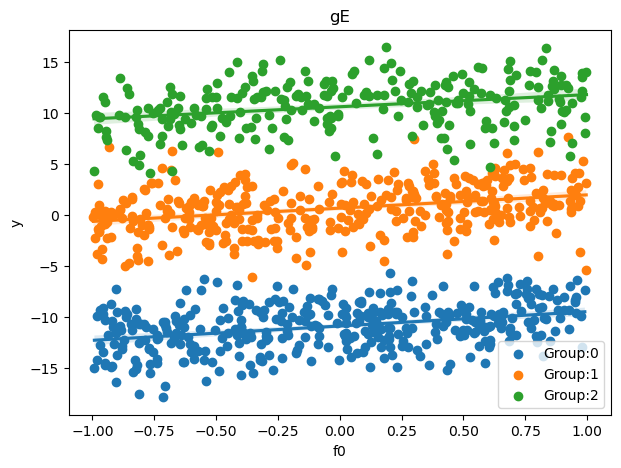

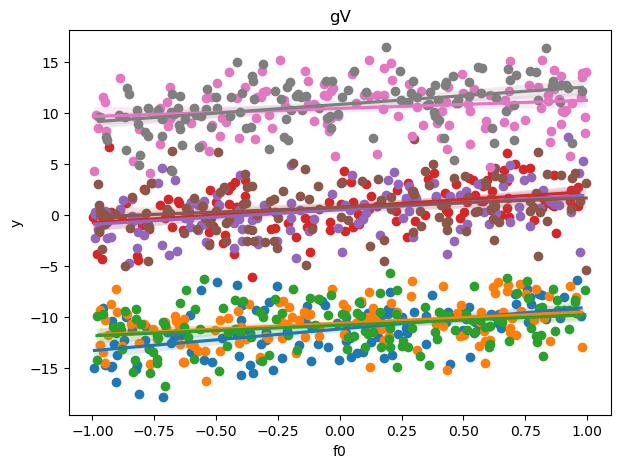

In [5]:
# For plotting only effective groups
plot_data(df,'f0', group = 'gE',legends = True)

# for plotting visible groups
plot_data(df,'f0', group = 'gV',legends = False) 

In [6]:
data = df.copy()

# Drop the unwanted group
data.drop('gE',axis=1, inplace=True)

In [7]:
X, y = data.drop(['y'], axis=1), data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

x_cols = [col for col in X.columns if col if not col.startswith('g')]    
g_col = [col for col in X.columns if col if col.startswith('g')]

scaler = StandardScaler()
X_train[x_cols] = scaler.fit_transform(X_train[x_cols])
X_test[x_cols]  = scaler.transform(X_test[x_cols])
data_train = pd.concat([X_train, y_train], axis=1)

In [8]:
# for intercept only
md = sm.MixedLM.from_formula(f"y ~ f0 + (1|{g_col[0]})", data_train, groups = g_col[0])

# for slope only
# md = sm.MixedLM.from_formula(f"y ~ f0", data_train, groups = g_col[0], re_formula = "~1+f0")

# for intercept & slope
# md = sm.MixedLM.from_formula(f"y ~ f0 + (1|{g_col[0]})", data_train, groups = g_col[0], re_formula = "~1+f0")

mdf = md.fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: y         
No. Observations: 670     Method:             REML      
No. Groups:       8       Scale:              4.9146    
Min. group size:  72      Log-Likelihood:     -1504.1678
Max. group size:  91      Converged:          Yes       
Mean group size:  83.8                                  
--------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  -15.153    2.606 -5.816 0.000 -20.259 -10.046
f0           0.811    0.086  9.402 0.000   0.642   0.980
1 | gV       3.498    0.569  6.152 0.000   2.383   4.612
gV Var      12.873    3.383                             
========================================================

"""

In [9]:
mdf.fe_params

Intercept   -15.152682
f0            0.811253
1 | gV        3.497710
dtype: float64

In [10]:
mdf.random_effects

{0: gV    0.328405
 dtype: float64,
 1: gV    1.155859
 dtype: float64,
 2: gV   -5.996818
 dtype: float64,
 3: gV    5.500757
 dtype: float64,
 4: gV   -1.860505
 dtype: float64,
 5: gV   -1.600163
 dtype: float64,
 6: gV    0.949277
 dtype: float64,
 7: gV    1.523189
 dtype: float64}

In [11]:
# Fixed effects Prediction
pred_fe = mdf.predict(X_test)

# Adding Random effects Prediction to Fixed effects Prediction
preds = pred_fe.copy()
for i in X_test.index:

    preds[i] = preds[i] + mdf.random_effects[X_test.at[i,str(g_col[0])]][0]
    
    # if re_formula is used
    try:
        for itr, f in enumerate(x_cols):
            preds[i] += mdf.random_effects[X_test.at[i,str(g_col[0])]][1] * X_test.at[i,'f0']
    except (KeyError, IndexError): pass

MSE:  4.8923524746406715


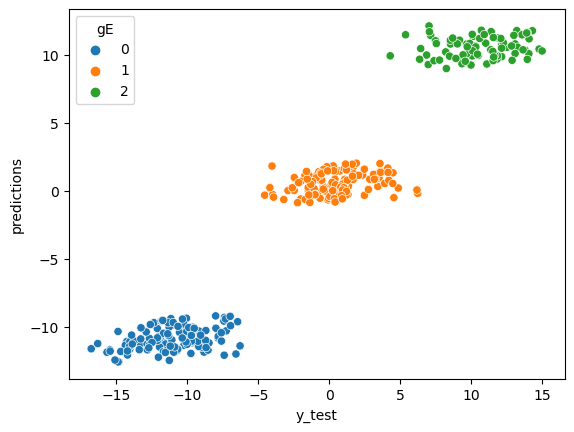

In [12]:
print("MSE: ", np.mean((preds - y_test)**2))
plot_prediction(y_test, preds, group = 'gE', reference_df=df)

# The below function does the same directly

In [13]:
def MixedLM(df, mode, calculate_for = None):
    """
    output_array = mse, time, y_test, y_pred
    
    """
    
    dataframe = df.copy()    
    allowed_modes = ['intercept', 'slope', 'both']
    
    if mode not in allowed_modes:
        raise ValueError(f"Invalid mode '{mode}'. Please choose one of {', '.join(allowed_modes)}.")
    if calculate_for:
        dataframe = dataframe.drop([col for col in dataframe.columns if col if col.startswith('g') \
                                                                and col != calculate_for], axis=1)
        
    X, y = dataframe.drop('y', axis=1), dataframe['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    x_cols = [col for col in X.columns if col if not col.startswith('g')]    
    g_cols = [col for col in X.columns if col if col.startswith('g')]
    
    scaler = StandardScaler()
    X_train[x_cols] = scaler.fit_transform(X_train[x_cols])
    X_test[x_cols]  = scaler.transform(X_test[x_cols])
    data_train = pd.concat([X_train, y_train], axis=1)
    
    start = time.time()
    
    if mode == 'intercept':
        md = sm.MixedLM.from_formula(f"y ~ {' + '.join([i for i in X.columns if i.startswith('f')])} + (1|{g_cols[0]})", \
         data_train, groups = str(g_cols[0]))
        
    if mode == 'slope':
        md = sm.MixedLM.from_formula(f"y ~ {' + '.join([i for i in X.columns if i.startswith('f')])}", \
         data_train, re_formula = '~'+'+'.join([i for i in df.columns if i.startswith('f')]), groups = str(g_cols[0]))
        
    if mode == 'both':
        md = sm.MixedLM.from_formula(f"y ~ {' + '.join([i for i in X.columns if i.startswith('f')])} + (1|{g_cols[0]})", \
         data_train, re_formula = '~'+'+'.join([i for i in df.columns if i.startswith('f')]), groups = str(g_cols[0]))
    
    mdf = md.fit()
    
    preds = mdf.predict(X_test)
    
    for i in X_test.index:

        preds[i] = preds[i] + mdf.random_effects[X_test.at[i,str(g_cols[0])]][0]

        try:
            for itr, f in enumerate(x_cols):
                preds[i] = preds[i] + mdf.random_effects[X_test.at[i,str(g_cols[0])]][itr+1] * X_test.at[i,str(f)]
        except (KeyError, IndexError): pass
    
    end = time.time()
    
    MSE = np.mean((preds - y_test)**2)
    
    return MSE, end-start, y_test, preds

In [14]:
np.random.seed(10)
df,b = create_data_linspace(n=1000,
                            n_effective_groups=3, # gE
                            n_visible_groups=8,   # gV
                            n_contineous_features=1,
                            mode = 'intercept',
                           show_random_effects=False)

df['y'] = df.y + np.random.normal(0,2, size = len(df))
df

,f0,gE,gV,y
0,0.542641,0,0,-11.579654
1,-0.958496,0,0,-9.089844
2,0.267296,0,0,-11.095287
3,0.497608,0,0,-11.317915
4,-0.002986,0,0,-14.235201
...,...,...,...,...
995,0.031177,2,7,12.250508
996,-0.579693,2,7,9.816872
997,-0.669775,2,7,9.912663
998,0.379896,2,7,10.107756


MSE:  4.8336950967085075


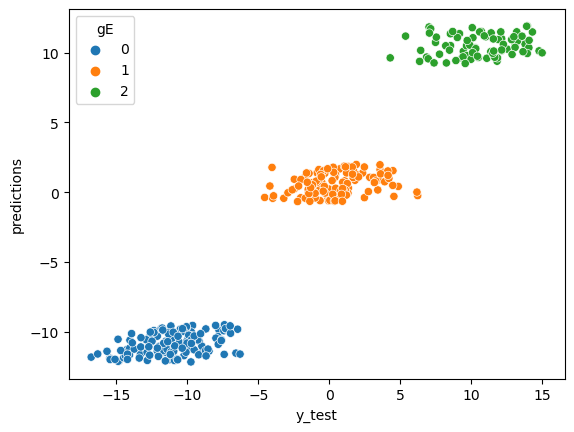

In [15]:
re = MixedLM(df, mode = 'intercept', calculate_for='gE') # output: re =  [mse, time, y_test, preds]

print("MSE: ", re[0])
plot_prediction(re[2],re[3],'gE', reference_df = df)

# If we shuffle(randomize) one of the groups 

In [16]:
np.random.seed(10)
df,b = create_data_linspace(n=1000,
                            n_effective_groups=3, # gE
                            n_visible_groups=8,   # gV
                            n_contineous_features=1,
                            mode = 'intercept',
                           show_random_effects=False)

df['y'] = df.y + np.random.normal(0,2, size = len(df))

df['gE'] = df['gE'].sample(frac=1).reset_index(drop=True)

In [17]:
df

,f0,gE,gV,y
0,0.542641,0,0,-11.579654
1,-0.958496,0,0,-9.089844
2,0.267296,2,0,-11.095287
3,0.497608,2,0,-11.317915
4,-0.002986,2,0,-14.235201
...,...,...,...,...
995,0.031177,0,7,12.250508
996,-0.579693,0,7,9.816872
997,-0.669775,1,7,9.912663
998,0.379896,0,7,10.107756


MSE:  78.20190433248666


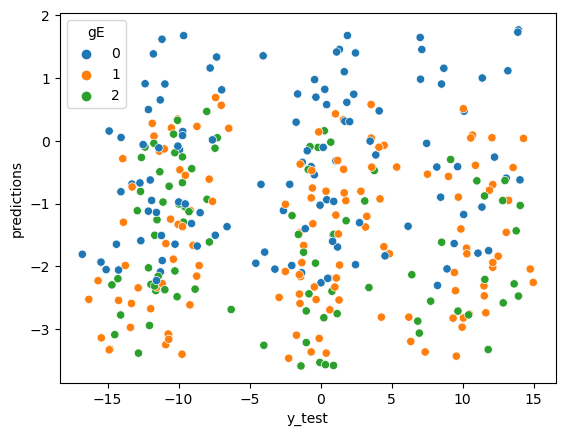

In [18]:
re = MixedLM(df, mode = 'intercept', calculate_for='gE') # output: re =  [mse, time, y_test, preds]

print("MSE: ", re[0])
plot_prediction(re[2],re[3],'gE', reference_df = df)